In [30]:
from utilities import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import pickle
import os

plt.rcParams['font.size'] = 18

# Loading tail angles

In [20]:
path_dataset1 = 'C:/Users/Antoine/Documents/cours/automne 2023/machine leanring/github/ML_Zebrafish/data/dataset1-wholebrain/'
path_dataset2 = 'C:/Users/Antoine/Documents/cours/automne 2023/machine leanring/github/ML_Zebrafish/data/dataset2-mutants/'

paths = [path_dataset1, path_dataset2]

In [21]:
files1 = identify_files(path_dataset1, ['tail_angles', '.npy'])
files2 = identify_files(path_dataset2, ['tail_angles', '.npy'])


# Extracting swim bouts

In [22]:
fps = 399.75

In [23]:
tails = []

for path in paths:
    
    files = identify_files(path, ['tail_angles', '.npy'])
    
    for file in files:
        
        angles = np.load(path + file)
        tail = TailAnalysis(angles, fps)
        tail.detect_swim_bouts(threshold=0.75)
        tails.append(tail.curvature)       
        #fig, ax = plt.subplots(figsize=(30, 10))
        #ymax = np.max(np.abs(tail.curvature))
        #ax.plot(tail.curvature, color='black')
        #ax.spines[['top', 'right']].set_visible(False)
        #ax.fill_between(np.arange(len(tail.curvature)), -100 * ymax, 200 * tail.events - 100, color='red', alpha=0.25)
        #plt.title(file)
        #ax.set_ylim([-1.1 * ymax, 1.1 * ymax])
        #ax.set_xlim(46550,46770)


#### Binary conversion 


C:\Users\Antoine\AppData\Local\Temp\ipykernel_25488\3980205076.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.segmentation_dict[row[0]] = segment_list


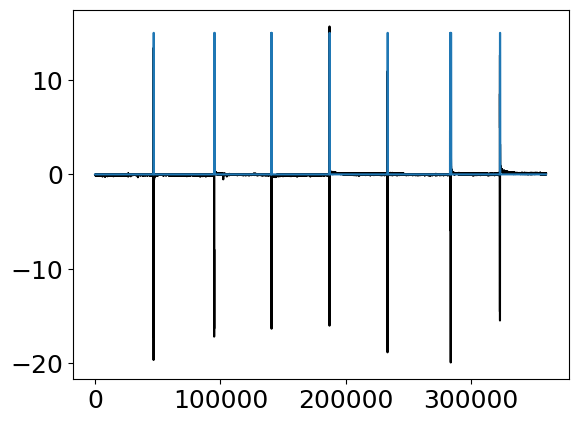

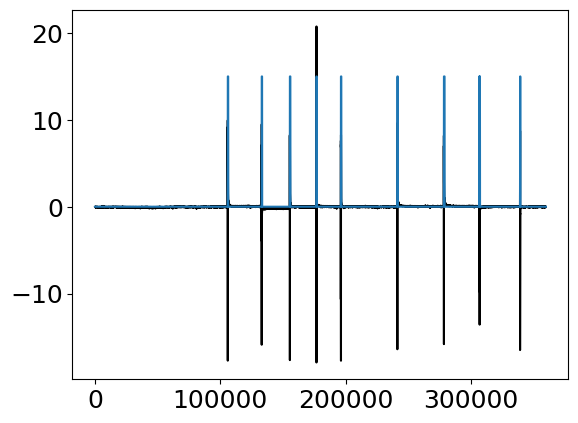

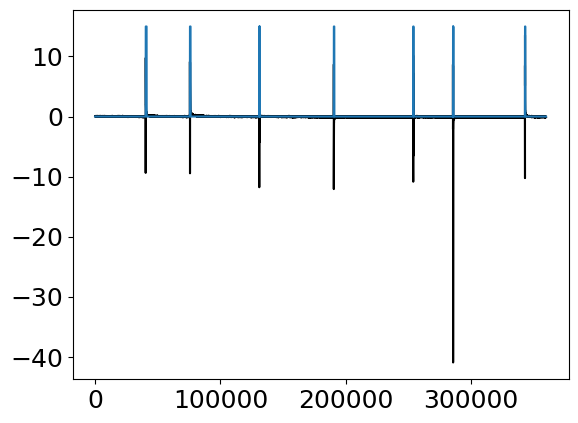

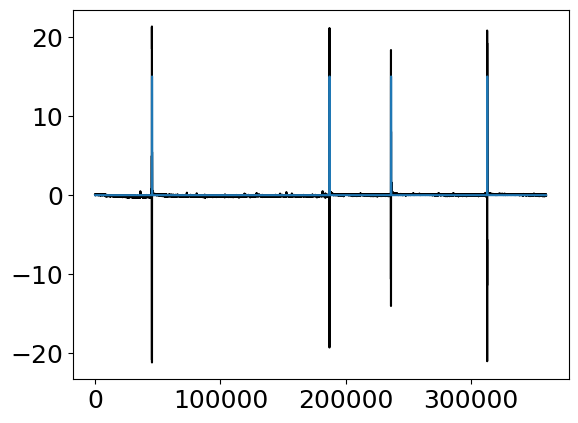

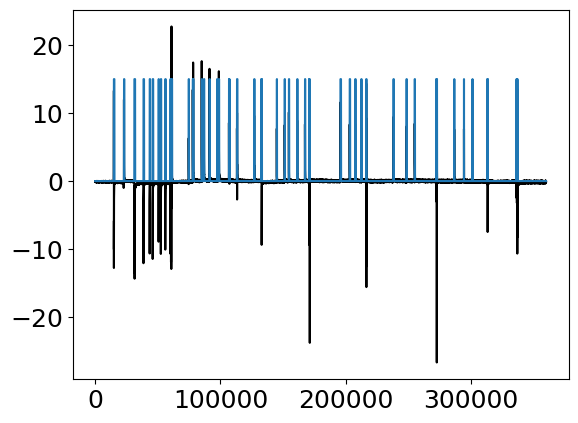

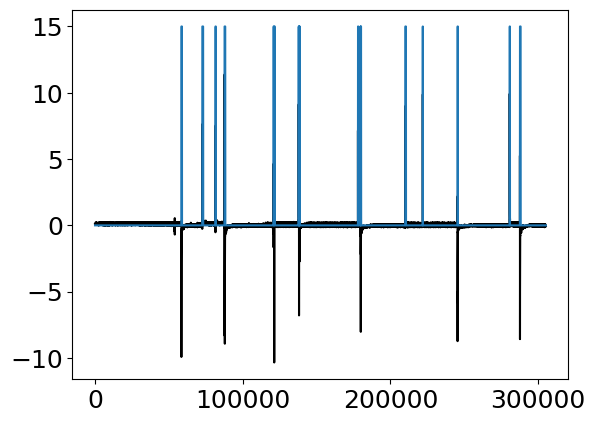

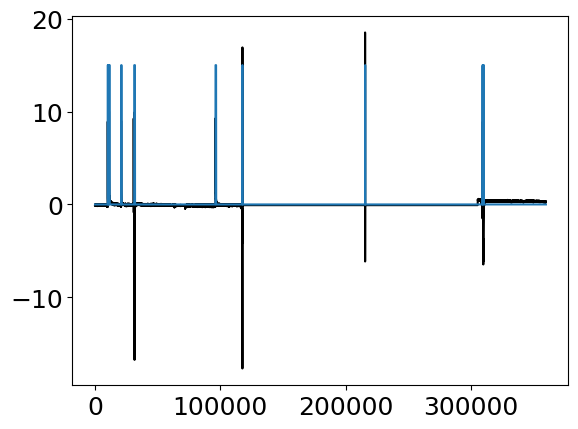

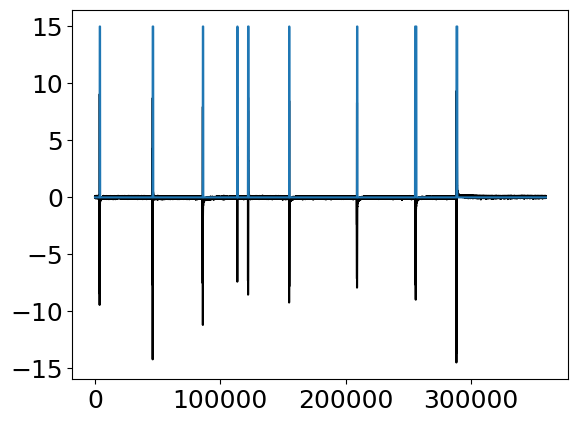

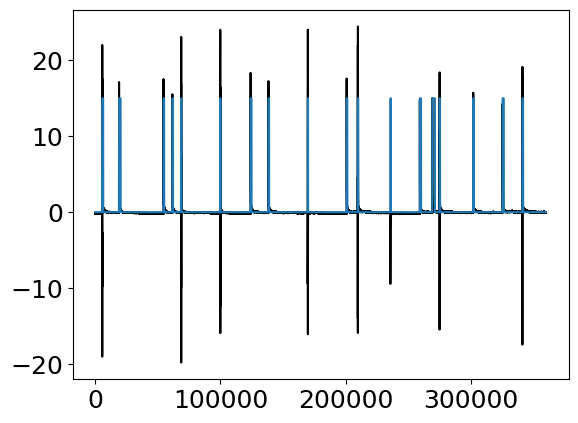

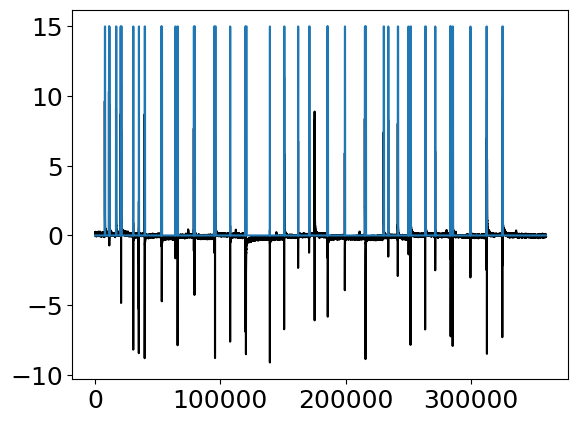

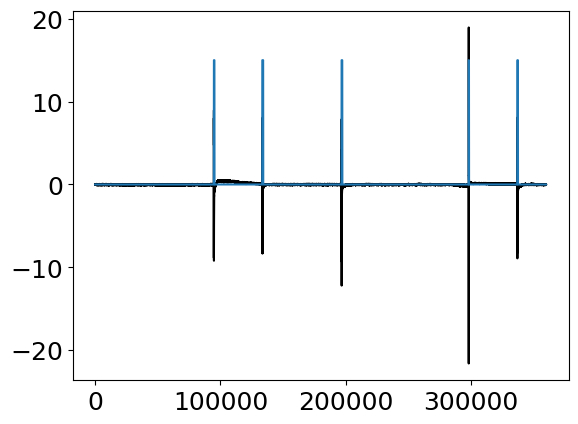

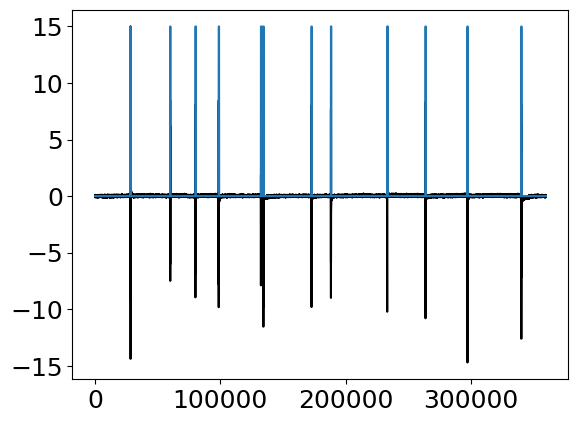

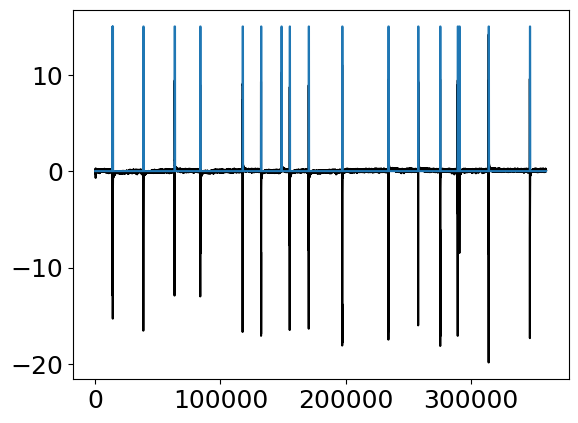

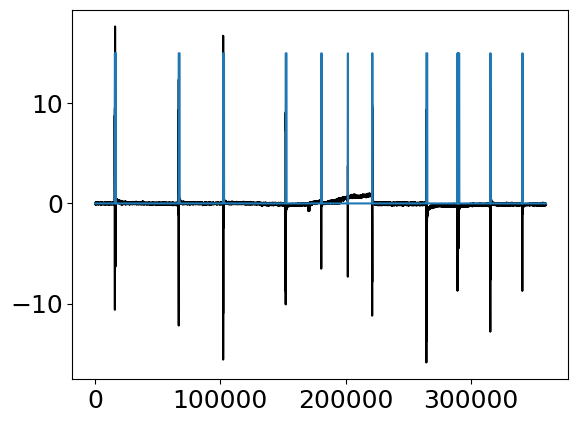

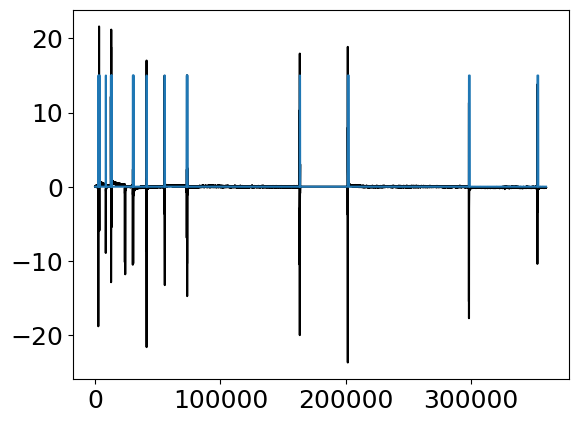

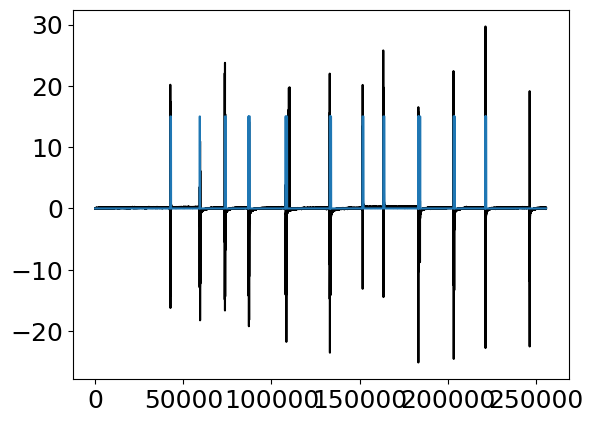

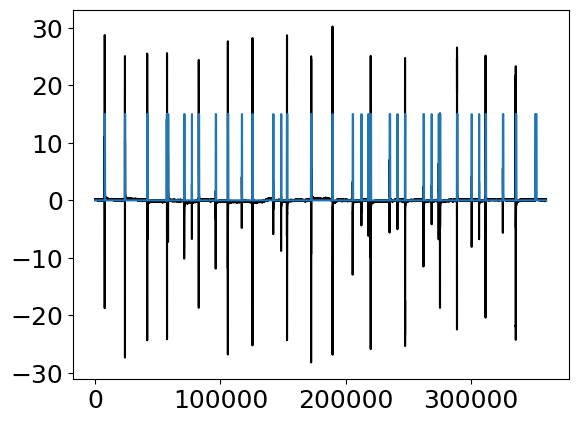

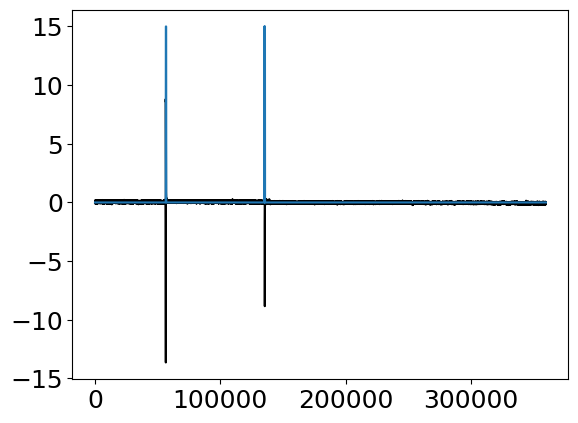

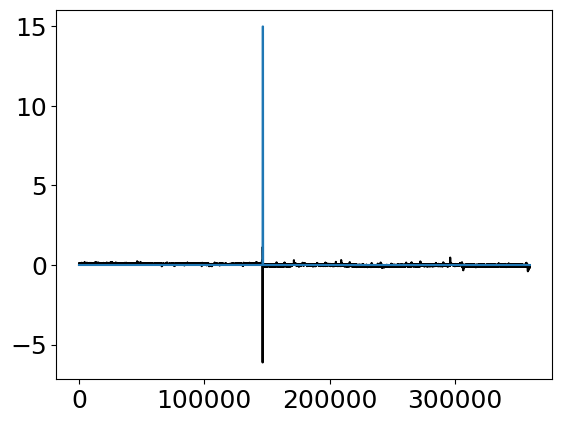

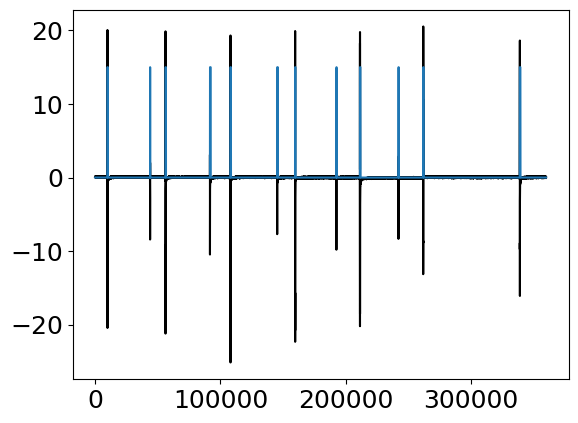

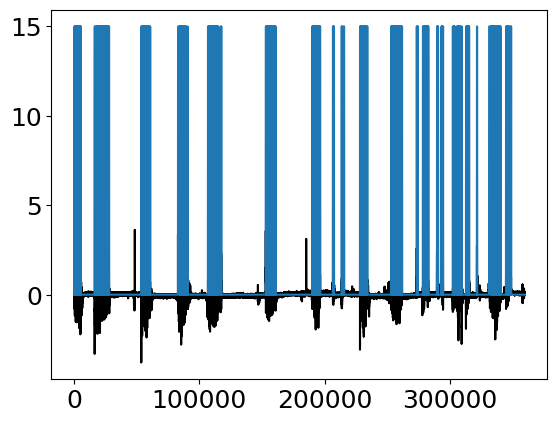

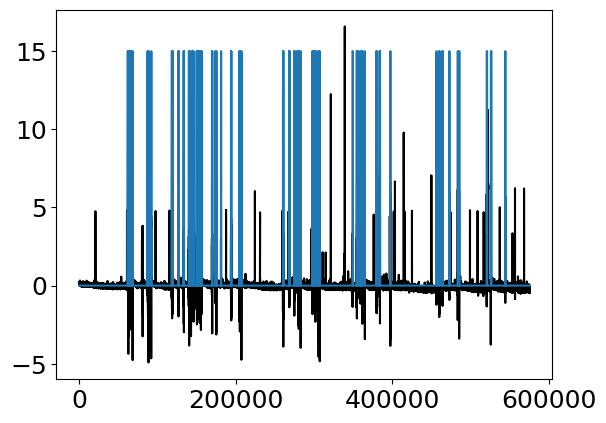

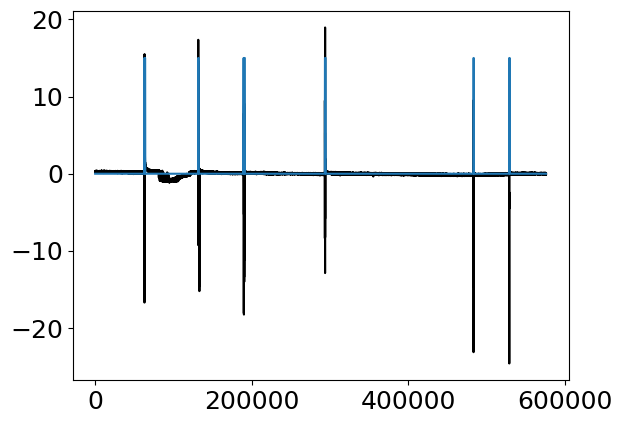

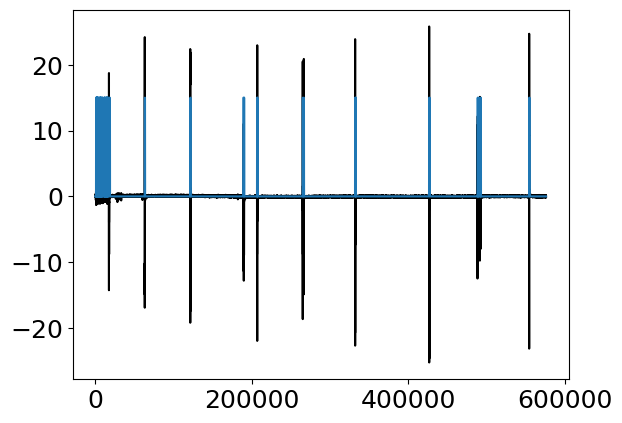

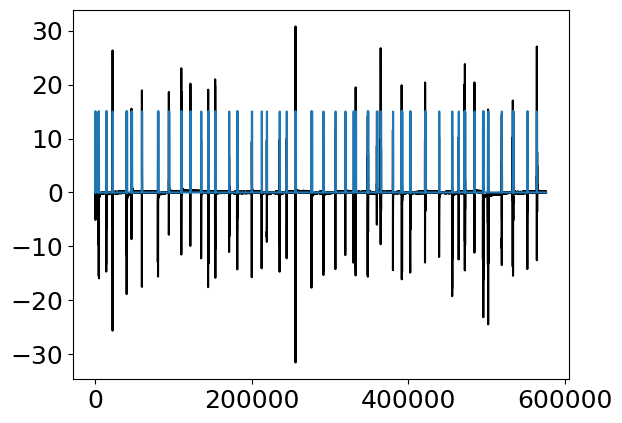

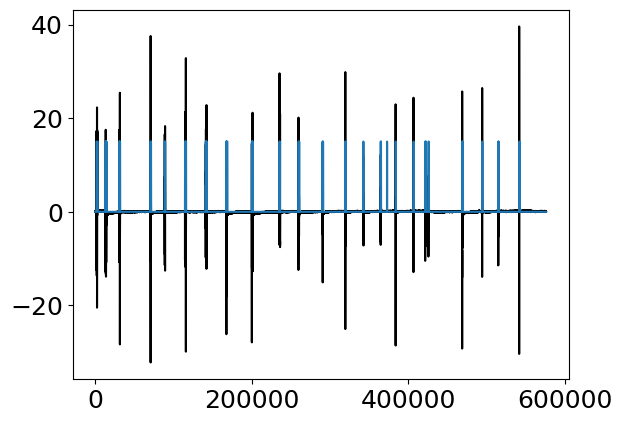

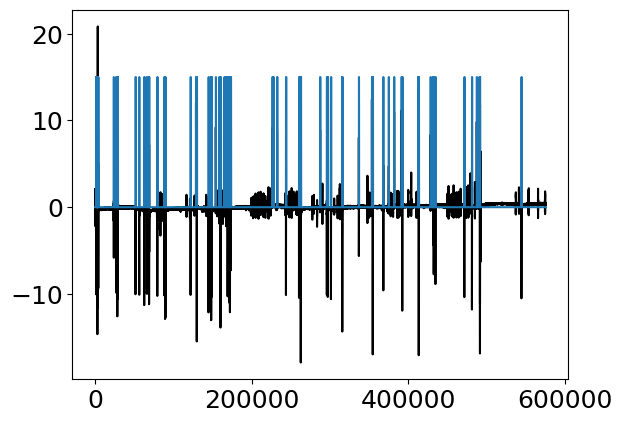

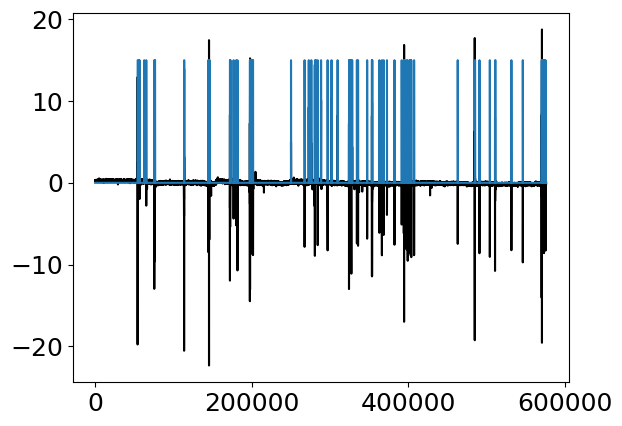

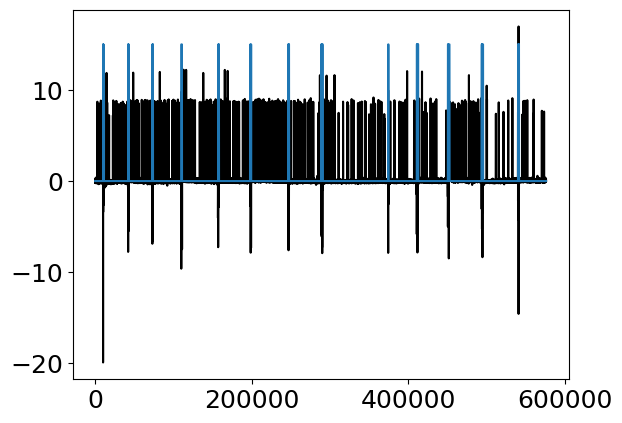

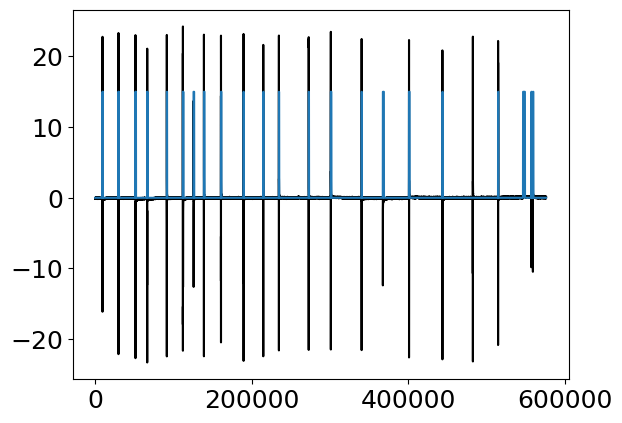

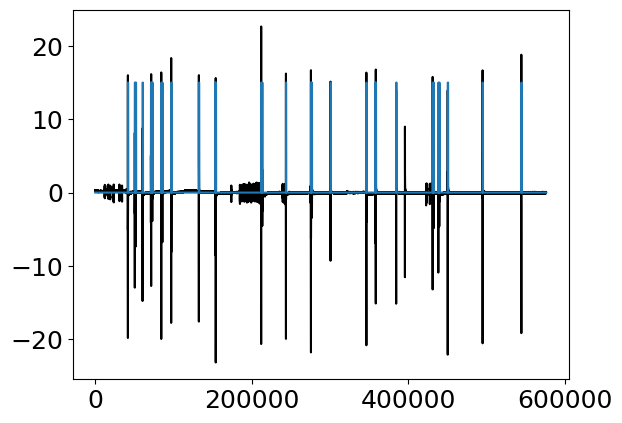

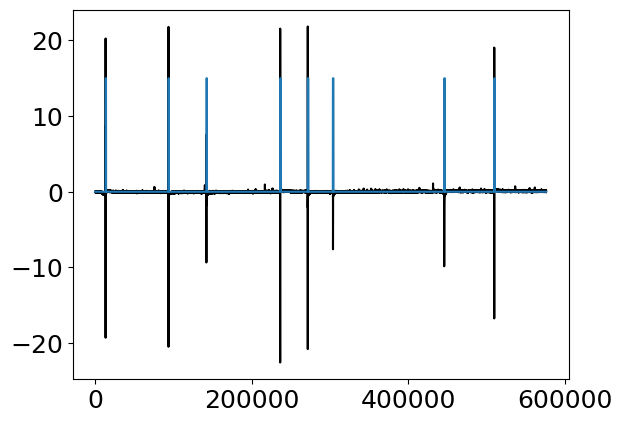

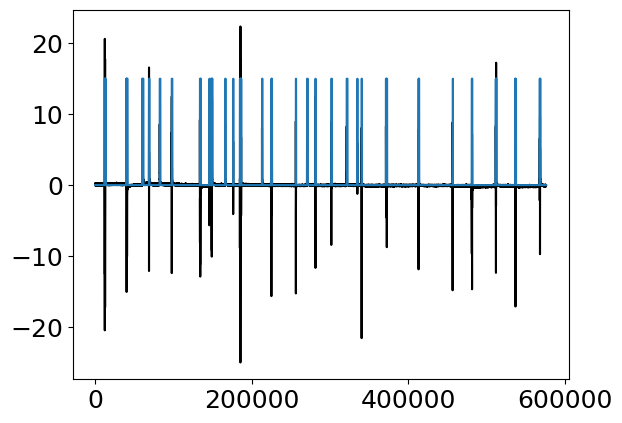

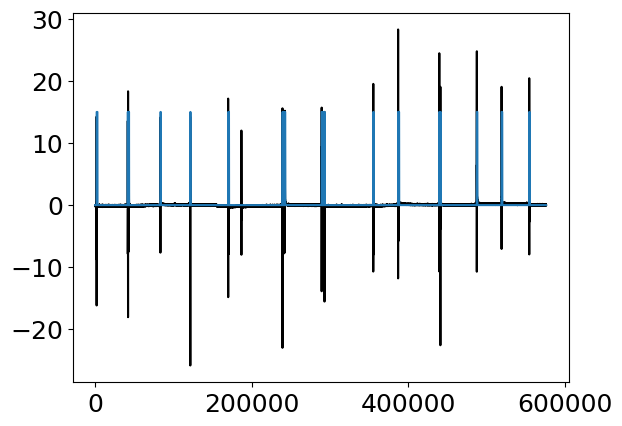

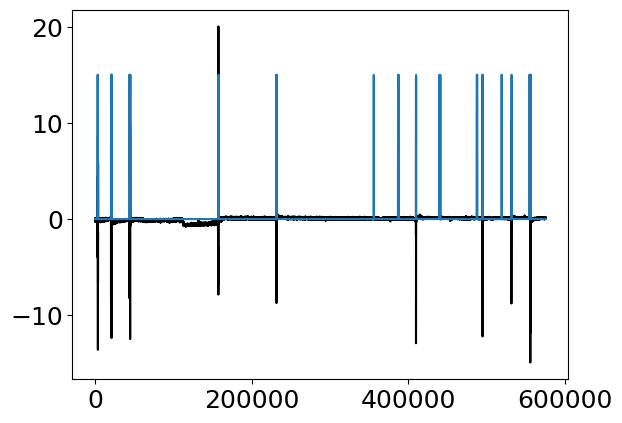

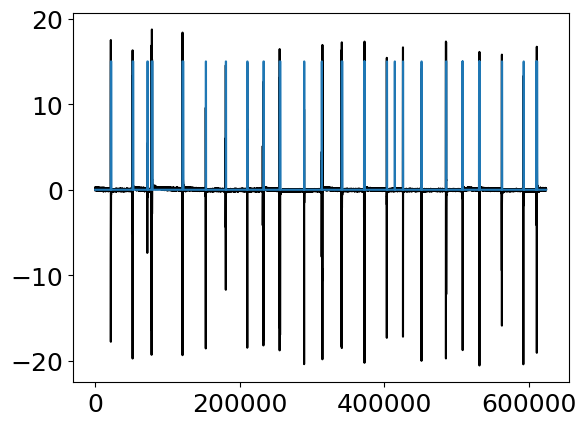

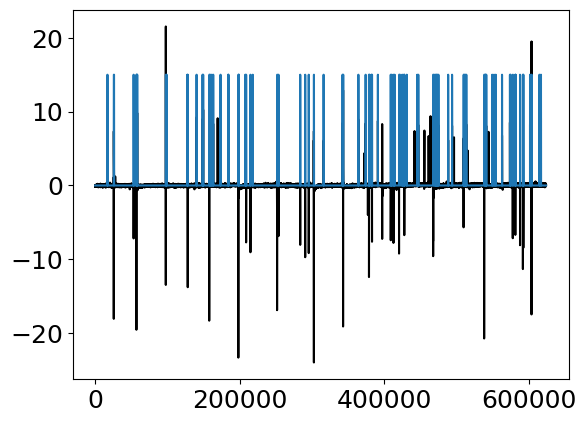

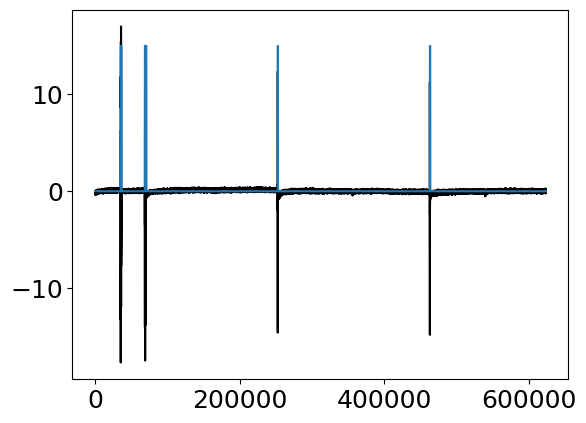

In [32]:
class ManualSegmentationExcelData:
    def __init__(self, excel_file_path):
        """
        Initialise la classe avec le chemin vers le fichier Excel contenant la
        segmentation manuelle des signaux expérimentaux
        """
        self.excel_file_path = excel_file_path
        self.df = None
        self.binary_matrix = None
        self.training_signal_indices = None
        self.segmentation_dict = {}
        

    def read_excel_file(self):
        """
        Lecture du fichier Excel au format spécifique
        """
        self.df = pd.read_excel(self.excel_file_path)
        self.df = self.df.dropna(subset=[self.df.columns[1]])

    def process_data(self):
        """
        Traitement des données avec les indices des signaux d'entraînement
        et initialisation de la matrice binaire
        """
        # Extraire les indices de la segmentation des signaux
        self.training_signal_indices = list(self.df[self.df.columns[0]])

        # Initialiser une matrice binaire
        self.binary_matrix = np.zeros((len(self.training_signal_indices), 625000), dtype=int)

        for i, row in self.df.iterrows():
            segment_list = []
            for col, value in row.items():
                # Vérifier s'il y a des Nan
                if pd.isna(value):
                    pass
                else:
                    # Vérifier si les valeurs sont des entiers
                    if isinstance(value, int):
                        pass
                    else:
                        # Convertir la chaîne '[a, b]' en une liste d'entiers
                        try:
                            integer_list = ast.literal_eval(value)
                            if isinstance(integer_list, list) and all(isinstance(x, int) for x in integer_list):
                                segment_list += [integer_list]
                            else:
                                print(f"Column: {col}, Value: {value} (not converted to a valid list of integers)")
                        except (ValueError, SyntaxError):
                            print(f"Column: {col}, Value: {value} (not converted to a list of integers)")
            self.segmentation_dict[row[0]] = segment_list


    def combine_lists(self, segment_list):
        """
        Combiner les segments de la liste en une seule liste d'indices
        """
        combined_list = []
        for segment in segment_list:
            combined_list += list(np.arange(segment[0], segment[1], 1))
        return combined_list

    def generate_full_binary_list(self):
        """
        Génèrer la matrice binaire en binarisant les signaux à partir de la segmentation
        """
        
        full_list = []
        for signal_index in self.segmentation_dict.keys():
            full_list.append(np.array(self.binarize_signal(self.segmentation_dict[signal_index], len(tails[signal_index]))))
        return full_list

    def binarize_signal(self, segment_list,lenght):
        """
        Binarise un signal à partir de la liste de segments
        """
        
        binarized_signal = np.zeros(lenght)
        binarized_signal[self.combine_lists(segment_list)] = 1
        return binarized_signal

    def plot_binary_matrix_example(self):
        """
        Affiche un exemple de la matrice binaire générée
        """
        for i in range(len(tails)):
            plt.plot(tails[i], color='black')
            plt.plot(np.arange(len(tails[i])), 15 * np.array(self.binarize_signal(self.segmentation_dict[i],len(tails[i]))))
            plt.show()


a=ManualSegmentationExcelData('C:/Users/Antoine/Documents/cours/automne 2023/machine leanring/github/ML_Zebrafish/data/SegmentationManuelle_ML.xlsx')
a.read_excel_file()
a.process_data()
a.plot_binary_matrix_example()
# La liste que vous souhaitez enregistrer


#### Counting total number of swim events

In [7]:
N_swim_bouts = []
for tail in tails:
    N_swim_bouts.append(len(tail.swim_bouts))

In [8]:
print('Dataset 1')
print('Total number of swim bouts:')
print(np.sum(N_swim_bouts))
print('Average swim bouts per fish (dataset 1):')
print('{:.2f}'.format(np.mean(N_swim_bouts)), '+/-', '{:.2f}'.format(np.std(N_swim_bouts)))

Dataset 1
Total number of swim bouts:
991
Average swim bouts per fish (dataset 1):
47.19 +/- 137.63


# Clustering swim bouts

In [9]:
t = tails[0].t * 1000 # In milliseconds

#### Compiling events across fish

In [10]:
swim_bouts = []
for tail in tails:
    swim_bouts += tail.swim_bouts

print(len(swim_bouts))

991


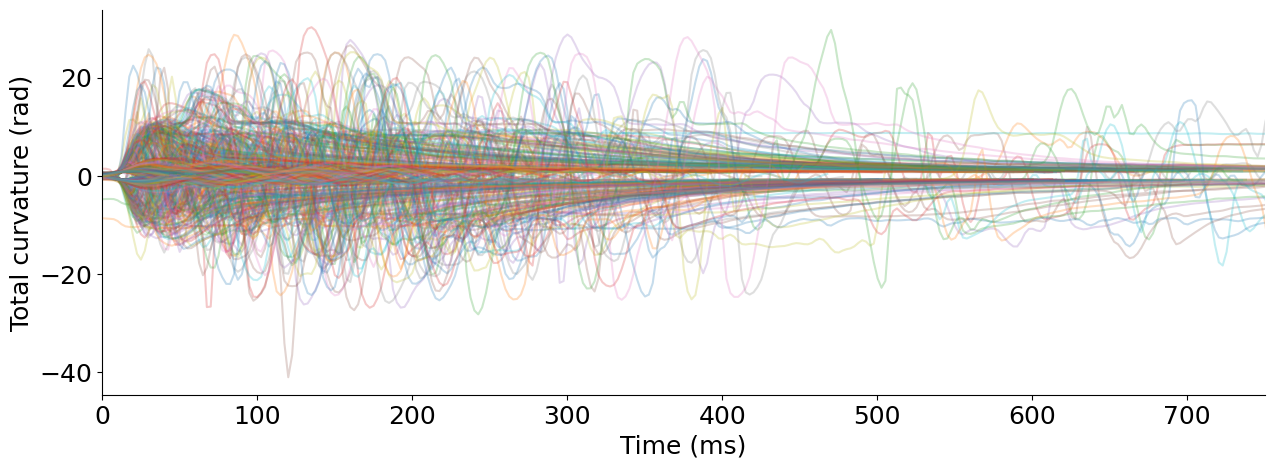

In [11]:
fig, ax = plt.subplots(figsize=(15, 5))
for i in range(len(swim_bouts)):
    plt.plot(t[:swim_bouts[i].shape[1]], np.sum(swim_bouts[i], axis=0), alpha=0.25)
plt.xlim([0, 750])
plt.xlabel('Time (ms)')
plt.ylabel('Total curvature (rad)')
ax.spines[['top', 'right']].set_visible(False)

#### Clustering